## Install Dependencies

In [ ]:
# Connecting to Google drive in order to store the weights of the agents HDF5 files.
from google.colab import drive

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [ ]:
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

In [ ]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 159 kB 4.2 MB/s 
     |████████████████████████████████| 106 kB 44.7 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=92989be733755c374fe8a0fe75792c3733bc7e217f06012bb6b37fd6639b8853
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9155 sha256=0947b73f642fb59c03f4ce2bd00437f4779f9fa246c2c5be6297239ceb1e5fb5
  Stored in directory: /root/.cache/pip/wheels/bf/5e/dd/9670c2d20867bcff6eb19199822f6b32f16bbe01bea1cd35a8
Successfully built tensorflow-determinism


## Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import pickle
import sys
import datetime
import cv2
import random
import random as python_random
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
   os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
np.random.seed(seed_value)
vec = np.random.randint(1, 10)
print(vec)
random.seed(42)
print(random.random())
tf.random.set_seed(42)
print(tf.random.uniform([1])) 

7
0.6394267984578837
tf.Tensor([0.6645621], shape=(1,), dtype=float32)


## Extracting Data

In [ ]:
module = os.path.abspath('./WESAD/')
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

## Data Preprocessing

In [ ]:
# config
debug = False;

In [ ]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [ ]:
test_subject = [17]
rest_subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]

In [ ]:
def generateData(subject_ids):
    data = DataManager()
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);

#     subject_ids = [2, 3]

    for subject_id in subject_ids:
        if(debug): print("Processing subject id: ", subject_id);
        subject = data.load(subject_id)


        if(debug):
            print('baseline: ', subject[0], '\nstress: ', subject[1], '\namusement: ', subject[2], '\nbase_label: ', subject[3], '\nstress_label: ', subject[4], '\namuse_label: ', subject[5])

        ecg_base = subject[0]
        ecg_stress = subject[1]
        ecg_amusement = subject[2]

        base_label = subject[3]
        stress_label = subject[4]
        amuse_label = subject[5]

        ecg_base_T = ecg_base.T
        ecg_stress_T = ecg_stress.T
        ecg_amusement_T = ecg_amusement.T

        ecg_base_data = ecg_base_T[0]
        ecg_stress_data = ecg_stress_T[0]
        ecg_amusement_data = ecg_amusement_T[0]

        ecg_base_label =  base_label.T
        ecg_stress_label  = stress_label.T
        ecg_amusement_label  = amuse_label.T

        if(debug):
            print('ecg_base_data:', ecg_base_data)
            print('ecg_stress_data:', ecg_stress_data)
            print('ecg_amusement_data:', ecg_amusement_data)

            print('ecg_base_label:', ecg_base_label)
            print('ecg_stress_label:', ecg_stress_label)
            print('ecg_amusement_label:', ecg_amusement_label)


        base_secs = len(ecg_base_data) // 700 # Number of seconds in signal X
        base_samps = int(base_secs * 256 )    # Number of samples to downsample
        base_down = signal.resample(ecg_base_data, base_samps)


        stress_secs = len(ecg_stress_data) // 700 # Number of seconds in signal X
        stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
        stress_down = signal.resample(ecg_stress_data, stress_samps)


        amuse_secs = len(ecg_amusement_data) // 700 # Number of seconds in signal X
        amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
        amuse_down = signal.resample(ecg_amusement_data, amuse_samps)

    #     heart_beat_base = np.array_split(base_down, 256)
    #     heart_beat_stress = np.array_split(stress_down, 256)
    #     heart_beat_amuse = np.array_split(amuse_down, 256)

        window_size = 256
        window_shift = 256

        heart_beat_base = []
        for i in range(0,len(base_down) - window_size,window_shift):
            heart_beat_base.append(base_down[i:window_size + i])
        heart_beat_base.pop()
    #     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

        heart_beat_stress = []
        for i in range(0,len(stress_down) - window_size,window_shift):
            heart_beat_stress.append(stress_down[i:window_size + i])
        heart_beat_stress.pop()
    #     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

        heart_beat_amuse = []
        for i in range(0,len(amuse_down) - window_size,window_shift):
            heart_beat_amuse.append(amuse_down[i:window_size + i])
        heart_beat_amuse.pop()
    #     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)


        for idx, idxval in enumerate(heart_beat_base):
            heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #Baseline = 0

        for idx, idxval in enumerate(heart_beat_stress):
            heart_beat_stress[idx] = (heart_beat_stress[idx] - heart_beat_stress[idx].min()) / heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_stress[idx] = np.append(heart_beat_stress[idx], 1.0) #Stress = 1    

        for idx, idxval in enumerate(heart_beat_amuse):
            heart_beat_amuse[idx] = (heart_beat_amuse[idx] - heart_beat_amuse[idx].min()) / heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_amuse[idx] = np.append(heart_beat_amuse[idx], 2.0) #Amusement = 2

    #     print("heart_beat_base:", len(heart_beat_base[0]), len(heart_beat_base[-2]), len(heart_beat_base[-1]))
    #     print("heart_beat_stress:", len(heart_beat_stress[0]), len(heart_beat_stress[-1]))
    #     print("heart_beat_amuse:", len(heart_beat_amuse[0]), len(heart_beat_amuse[-1]))

        heart_beat_all = np.concatenate((heart_beat_base, heart_beat_stress, heart_beat_amuse), axis=0)
        subject_data = np.array(list(heart_beat_all[:]), dtype=float)


        if(all_subject_data.size == 0):
            all_subject_data = subject_data
        else:
            if(subject_data.size != 0):
                all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

        print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
        
    #SMOTE to balance the data
    df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
    df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

    smote = SMOTE(sampling_strategy='not majority')
    X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
    
    return X_sm, y_sm

## Data Generation - Train

In [ ]:
train_data, train_labels = generateData(rest_subjects)

Loading data for S2
New data shape (2115, 257) Total Shape:  (2115, 257)
Loading data for S3
New data shape (2149, 257) Total Shape:  (4264, 257)
Loading data for S4
New data shape (2159, 257) Total Shape:  (6423, 257)
Loading data for S5
New data shape (2211, 257) Total Shape:  (8634, 257)
Loading data for S6
New data shape (2196, 257) Total Shape:  (10830, 257)
Loading data for S7
New data shape (2192, 257) Total Shape:  (13022, 257)
Loading data for S8
New data shape (2202, 257) Total Shape:  (15224, 257)
Loading data for S9
New data shape (2191, 257) Total Shape:  (17415, 257)
Loading data for S10
New data shape (2271, 257) Total Shape:  (19686, 257)
Loading data for S11
New data shape (2222, 257) Total Shape:  (21908, 257)
Loading data for S13
New data shape (2220, 257) Total Shape:  (24128, 257)
Loading data for S14
New data shape (2221, 257) Total Shape:  (26349, 257)
Loading data for S15
New data shape (2227, 257) Total Shape:  (28576, 257)
Loading data for S16
New data shape (

In [ ]:
train_labels.value_counts()

0.0    16402
1.0    16402
2.0    16402
dtype: int64

In [ ]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (49206, 256)
Train labels shape: (49206, 1)
Dimension: 2


In [ ]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [ ]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (49206,)
Dimension: 1


## Train and Validation data split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)

In [ ]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), Counter(y_val))

size of X_train: (34444, 256, 1)
size of X_val: (14762, 256, 1)
size of y_train: (34444,)
size of y_val: (14762,)
Train: Counter({1.0: 11489, 2.0: 11479, 0.0: 11476}) Counter({0.0: 4926, 2.0: 4923, 1.0: 4913})


## Data Generation - Test

In [ ]:
test_data, test_labels = generateData(test_subject)

Loading data for S17
New data shape (2270, 257) Total Shape:  (2270, 257)


In [ ]:
test_labels.value_counts()

0.0    1179
1.0    1179
2.0    1179
dtype: int64

In [ ]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3537, 256)
Test labels shape: (3537, 1)
Dimension: 2


In [ ]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [ ]:
print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3537,)
Dimension: 1


In [ ]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [ ]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3537, 256, 1)
size of y_test: (3537,)
Test: Counter({0.0: 1179, 1.0: 1179, 2.0: 1179})


## 1D CNN Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
reset_random_seeds()
# kernel_regularizer =tf.keras.regularizers.l2(l=0.004)
# initializer = tf.keras.initializers.HeUniform()
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', input_shape= (X_train.shape[1],1)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=15, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 3, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 5)            30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 10)           260       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 64, 10)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 15)            765       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 32, 15)           0

In [ ]:
print(cnn_model.layers[0])
print(cnn_model.layers[0].get_weights()[0])
print(cnn_model.layers[0].get_weights()[0].shape)
print(cnn_model.layers[0].get_weights()[1])

[[[ 0.14718884 -0.05276513 -0.1315859  -0.03176779 -0.4171068 ]]

 [[ 0.16517597  0.21476758  0.33312452 -0.24478115 -0.24758025]]

 [[-0.16959405  0.19886321 -0.32808736  0.04298964  0.06673217]]

 [[ 0.35748774 -0.43874902  0.01898932  0.12034023 -0.26892895]]

 [[ 0.20520169  0.04099566 -0.35100406  0.15805072  0.14335549]]]
(5, 1, 5)
[0. 0. 0. 0. 0.]


In [ ]:
# weights = 0.001 * (np.random.rand(5, 1, 5))
# print(weights)
# bias = np.random.rand(5)
# print(bias)

In [ ]:
# cnn_model.layers[0].set_weights([weights, bias])

In [ ]:
epochs=50
batch_size = 32

In [ ]:
def step_decay(epoch):
  initial_lrate = 0.005
  drop = 0.6
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [ ]:
opt = tf.keras.optimizers.SGD( learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50
1077/1077 - 14s - loss: 1.8849 - accuracy: 0.3814 - val_loss: 1.7917 - val_accuracy: 0.4140 - lr: 0.0050 - 14s/epoch - 13ms/step
Epoch 2/50
1077/1077 - 5s - loss: 1.7123 - accuracy: 0.4191 - val_loss: 1.6370 - val_accuracy: 0.4352 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 3/50
1077/1077 - 5s - loss: 1.5722 - accuracy: 0.4385 - val_loss: 1.5051 - val_accuracy: 0.4654 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 4/50
1077/1077 - 5s - loss: 1.4356 - accuracy: 0.4833 - val_loss: 1.3640 - val_accuracy: 0.4884 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 5/50
1077/1077 - 5s - loss: 1.3049 - accuracy: 0.5211 - val_loss: 1.2463 - val_accuracy: 0.5449 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 6/50
1077/1077 - 5s - loss: 1.2135 - accuracy: 0.5429 - val_loss: 1.1882 - val_accuracy: 0.5343 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 7/50
1077/1077 - 5s - loss: 1.1435 - accuracy: 0.5561 - val_loss: 1.1066 - val_accuracy: 0.5763 - lr: 0.0050 - 5s/epoch - 4ms/step
Epoch 8/50
1077/1077 - 5s - loss: 1.08

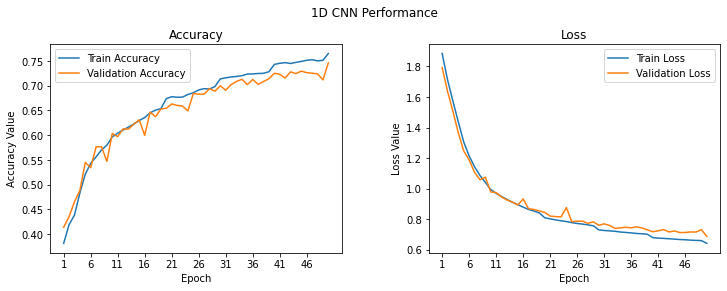

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
cnn_model.evaluate(X_test, y_test)

111/111 [==============================] - 0s 3ms/step - loss: 0.7670 - accuracy: 0.5858


[0.7670319080352783, 0.585807204246521]

In [ ]:
print(X_test.shape)
print(y_test.shape)

(3537, 256, 1)
(3537,)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_preds = np.around(cnn_model.predict(X_test))
print(y_test_preds)
# y_preds = np.argmax(y_test_preds, axis=1)
# y_test = np.argmax(y_test, axis=1)

111/111 [==============================] - 0s 2ms/step
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
y_test_preds.shape

(3537, 3)

In [ ]:
y_preds = np.argmax(y_test_preds, axis=1)

In [ ]:
y_preds.shape

(3537,)

In [ ]:
import sklearn.metrics as metrics

In [ ]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.37      0.42      0.39      1179
         1.0       0.95      0.94      0.95      1179
         2.0       0.35      0.30      0.32      1179

    accuracy                           0.56      3537
   macro avg       0.56      0.56      0.55      3537
weighted avg       0.56      0.56      0.55      3537



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 22 06:49:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |   1782MiB / 15109MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------